In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [12]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
customer_transactions = transactions.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')
customer_transactions.head()


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,Region
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Europe
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Asia
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Europe
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,South America
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Europe


In [13]:
 customer_profile = customer_transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    unique_products=('ProductID', 'nunique')
).reset_index()

customer_profile = customer_profile.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')
customer_profile.head()


,CustomerID,total_spend,transaction_count,unique_products,Region
0,C0001,3354.52,5,5,South America
1,C0002,1862.74,4,4,Asia
2,C0003,2725.38,4,4,South America
3,C0004,5354.88,8,8,South America
4,C0005,2034.24,3,3,Asia


In [14]:
features = customer_profile[['total_spend', 'transaction_count', 'unique_products']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[-0.06170143, -0.01145819,  0.05004655],
       [-0.87774353, -0.46749414, -0.42420409],
       [-0.40585722, -0.46749414, -0.42420409],
       [ 1.03254704,  1.35664965,  1.47279848],
       [-0.78392861, -0.92353008, -0.89845473]])

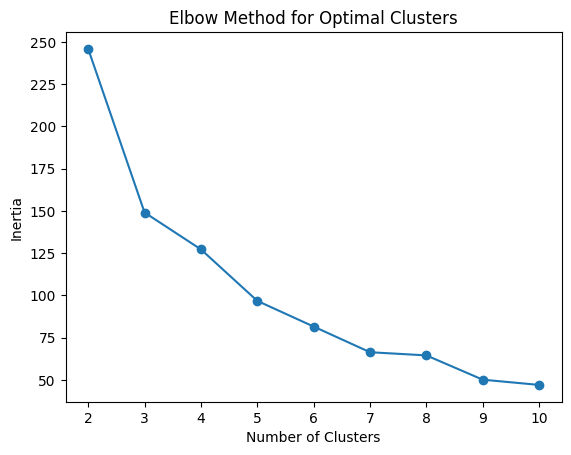

In [15]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [6]:
optimal_k = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_features)

# Check the cluster assignment
customer_profile.head()


,CustomerID,total_spend,transaction_count,unique_products,Region,Cluster
0,C0001,3354.52,5,5,South America,2
1,C0002,1862.74,4,4,Asia,1
2,C0003,2725.38,4,4,South America,2
3,C0004,5354.88,8,8,South America,3
4,C0005,2034.24,3,3,Asia,1


In [7]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_profile['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 0.9182221873822775


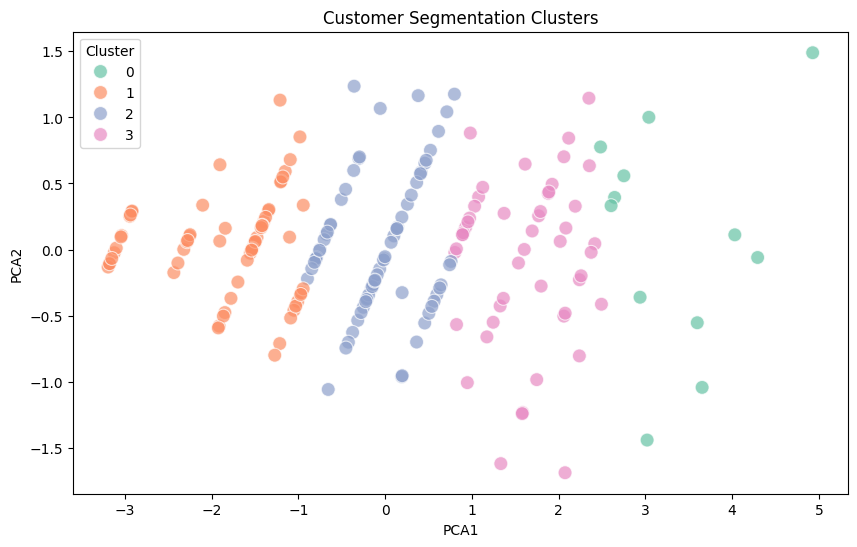

In [8]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Add PCA components to the customer profile dataframe
customer_profile['PCA1'] = pca_components[:, 0]
customer_profile['PCA2'] = pca_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=customer_profile, s=100, alpha=0.7)
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


In [9]:
# Print the cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['total_spend', 'transaction_count', 'unique_products'])
cluster_centers


,total_spend,transaction_count,unique_products
0,1.901025,1.926695,1.947049
1,-0.965640,-1.082781,-1.101705
2,-0.025740,-0.054022,-0.013187
3,0.815378,1.002989,0.959833


In [10]:
# Save the customer segmentation result
customer_profile.to_csv('Customer_Segmentation.csv', index=False)
